# House Price Prediction Model

## ` - import libraries`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from pandas.api.types import CategoricalDtype
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 600

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error


## ` - load datasets`

In [5]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df = pd.concat([df_train, df_test])
og_df = df.set_index(['Id'])

df = og_df.copy()


## ` - functions`

#### `plot functions`

In [6]:
# Plots for categorical features
def catPlot(feature):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(221)
    sns.countplot(x=feature)

    plt.subplot(222)
    sns.histplot(x=feature)

    plt.tight_layout()
    plt.show()

# Plots to compare old and new data
def old_new_catplot(feature):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(221)
    sns.countplot(x=og_df[feature])
    plt.title(f'Old Data Distribution ({feature})')
    
    plt.subplot(222)
    sns.countplot(x=df[feature])
    plt.title(f'New Data Distribution ({feature})')

    plt.subplot(223)
    sns.histplot(x=og_df[feature])
    plt.title(f'Old Data Distribution ({feature})')
    
    plt.subplot(224)
    sns.histplot(x=df[feature])
    plt.title(f'New Data Distribution ({feature})')
    
    plt.tight_layout()
    plt.show()

In [7]:
# Plots for numerical features
def numPlot(feature):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(221)
    sns.boxplot(x=feature)
    
    plt.subplot(222)
    sns.distplot(x=feature)
    
    plt.tight_layout()
    plt.show()

# Plots to compare old and new data
def old_new_numplot(feature):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(221)
    sns.boxplot(x=og_df[feature])
    plt.title(f'Old Data Distribution ({feature})')

    plt.subplot(222)
    sns.boxplot(x=df[feature])
    plt.title(f'New Data Distribution ({feature})')
    
    plt.subplot(223)
    sns.distplot(x=og_df[feature])
    plt.title(f'Old Data Distribution ({feature})')
    
    plt.subplot(224)
    sns.distplot(x=df[feature])
    plt.title(f'New Data Distribution ({feature})')
    
    plt.tight_layout()
    plt.show()

#### `feature functions`

In [8]:
# Function to Fill Null Values 
def fill_null(feature, value):
    feature.replace(np.nan, value, inplace=True)
    return feature.isna().sum()

# Index wise null feature info
def null_feature_info(index):
    null_feature = all_null_features[index-1:index]
    print(null_feature, '\n')

## ` - data description.txt`

In [9]:
data_desc = open('./data/data_description.txt', 'r')
data_description = data_desc.read()
print(data_description)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## ` - functions for data inspection`

In [10]:
# All features with Null values
null_count = df.isnull().sum()
null_count = pd.DataFrame(null_count[null_count > 0])
null_count[1] = null_count[0]/df.shape[0]*100
null_count[2] = df.dtypes
all_null_features = null_count.rename(columns={0:'null_count', 1:'in_%', 2:'data_type'})


In [11]:
# Features with object data type
object_features = df.select_dtypes(include=['object']).columns
# print(f"Total object features {object_features.shape[0]}")

# Object features with NULL values
null_object = df[object_features]
null_object = null_object.isnull().sum()
null_object = pd.DataFrame(null_object[null_object > 0])
null_object[1] = null_object[0]/df.shape[0]*100
null_object = null_object.rename(columns={0:'null_count', 1:'in_(%)'})
null_object_features = null_object.sort_values(by='null_count', ascending=False)


In [12]:
# Feature with numerical data types
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
# print(f"Total Numerical Features {numerical_features.shape[0]}")

# Numerical features with NULL values
null_numerical = df[numerical_features]
null_numerical = null_numerical.isnull().sum()
null_numerical = pd.DataFrame(null_numerical[null_numerical > 0])
null_numerical[1] = null_numerical[0]/df.shape[0]*100
null_numerical = null_numerical.rename(columns={0:'null_count', 1:'in_(%)'})
null_numerical_features = null_numerical.sort_values(by='null_count', ascending=False)


## ` - inspect the data`

In [13]:
df.shape

(2919, 80)

In [14]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [15]:
df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,NaN,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

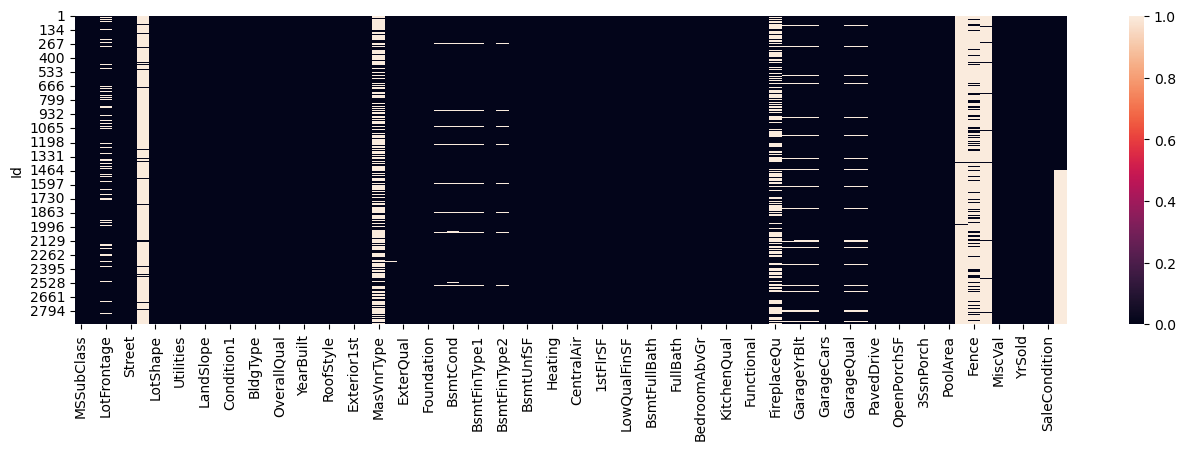

In [17]:
plt.figure(figsize=(16,4))
sns.heatmap(df.isnull())
plt.show()


In [18]:
null_numerical_features.head(2)

,null_count,in_(%)
SalePrice,1459,49.982871
LotFrontage,486,16.649538


In [19]:
null_object_features.head(2)

,null_count,in_(%)
PoolQC,2909,99.657417
MiscFeature,2814,96.402878


## ` - handling NULL values`

#### `1 : MSZoning`

In [20]:
null_feature_info(1)

          null_count      in_% data_type
MSZoning           4  0.137033    object 



In [21]:
df.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH', nan], dtype=object)

In [22]:
df.MSZoning.value_counts()

MSZoning
RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: count, dtype: int64

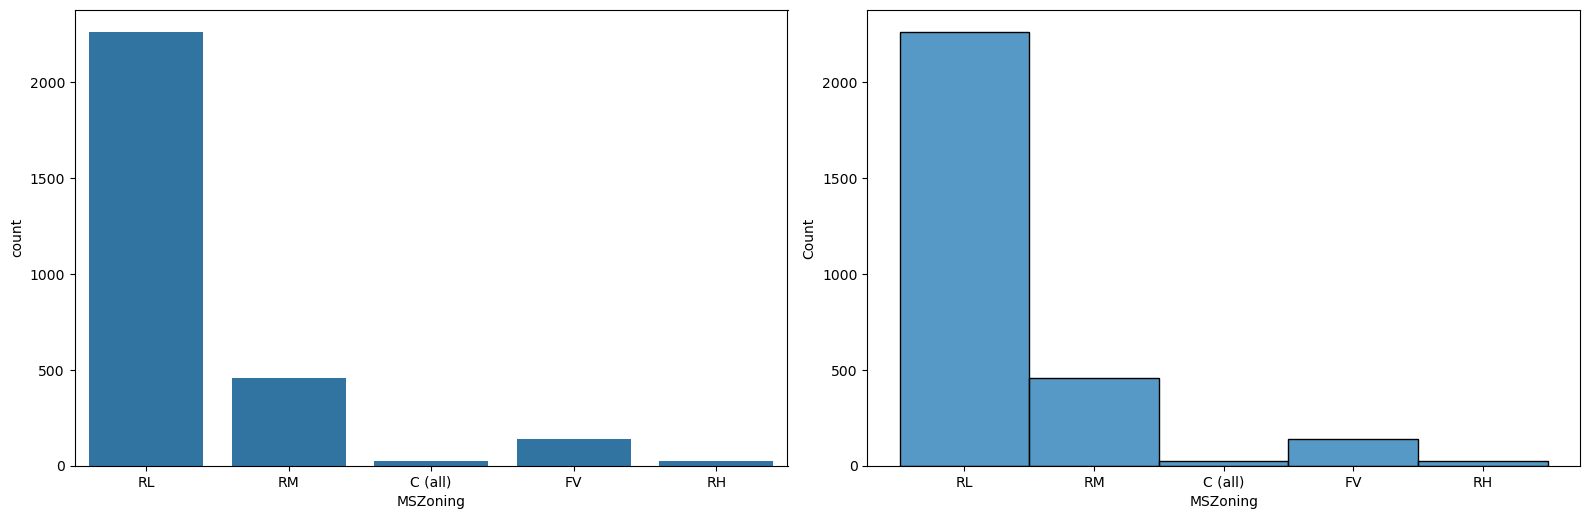

In [23]:
catPlot(df.MSZoning)

In [24]:
mszoning_mode = df.MSZoning.mode()[0]
fill_null(df.MSZoning, mszoning_mode)

0

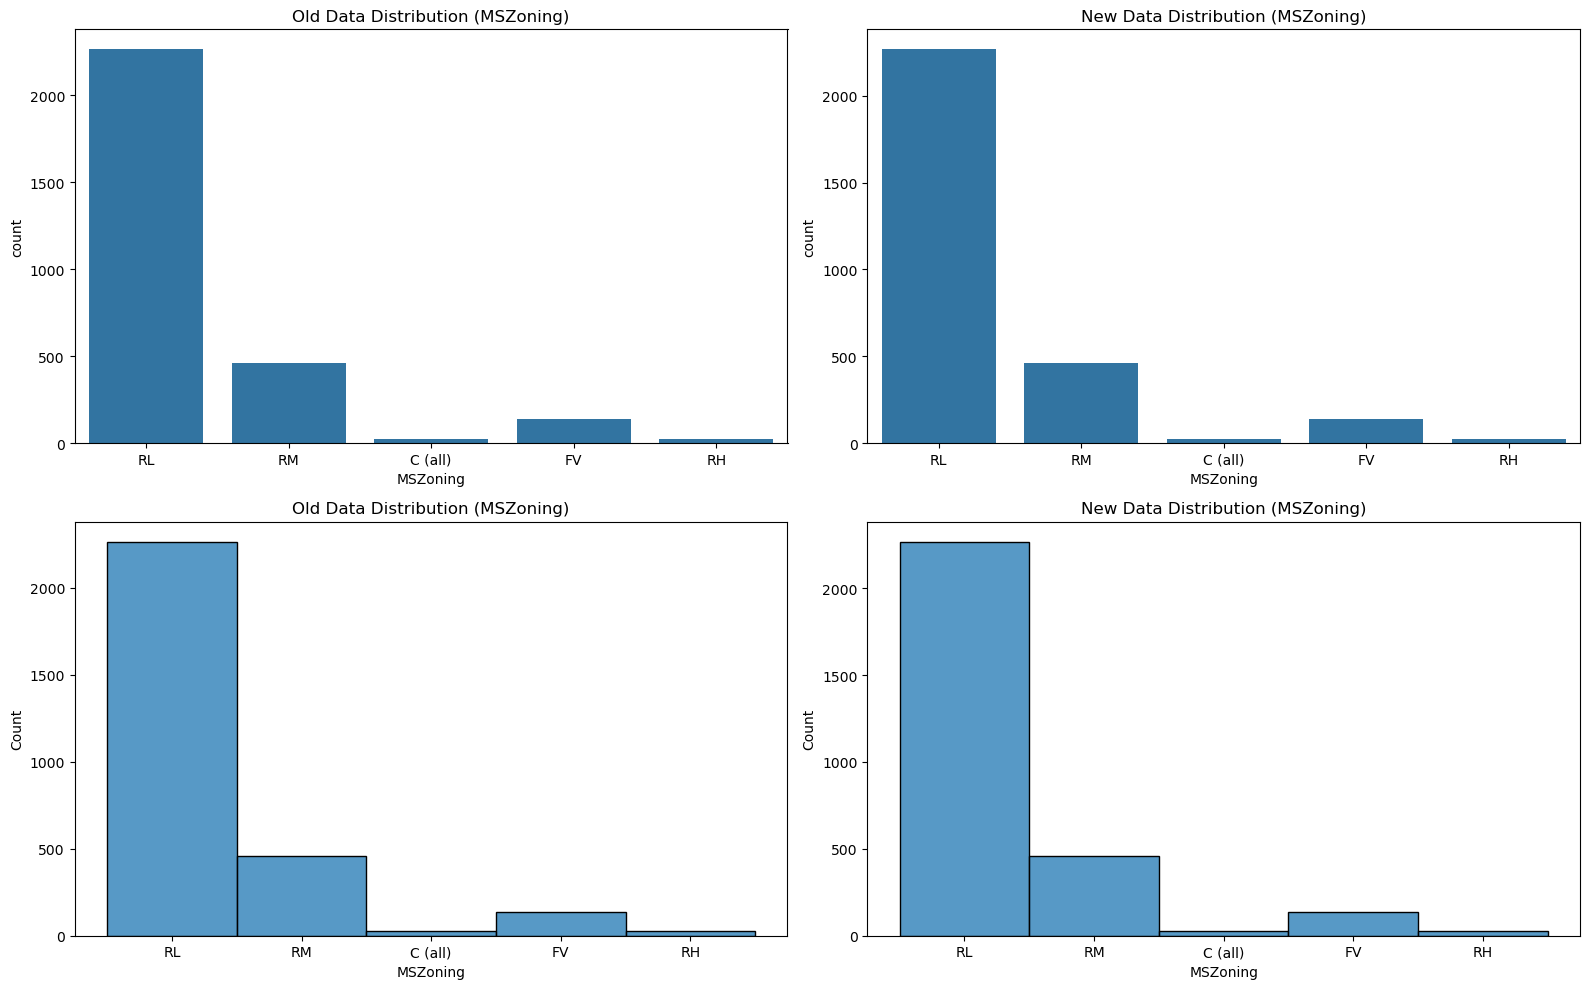

In [25]:
old_new_catplot('MSZoning')

#### `2 : LotFrontage`

In [26]:
null_feature_info(2)

             null_count       in_% data_type
LotFrontage         486  16.649538   float64 



In [27]:
df.LotFrontage.isna().value_counts()

LotFrontage
False    2433
True      486
Name: count, dtype: int64

In [28]:
df.LotFrontage.describe()

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

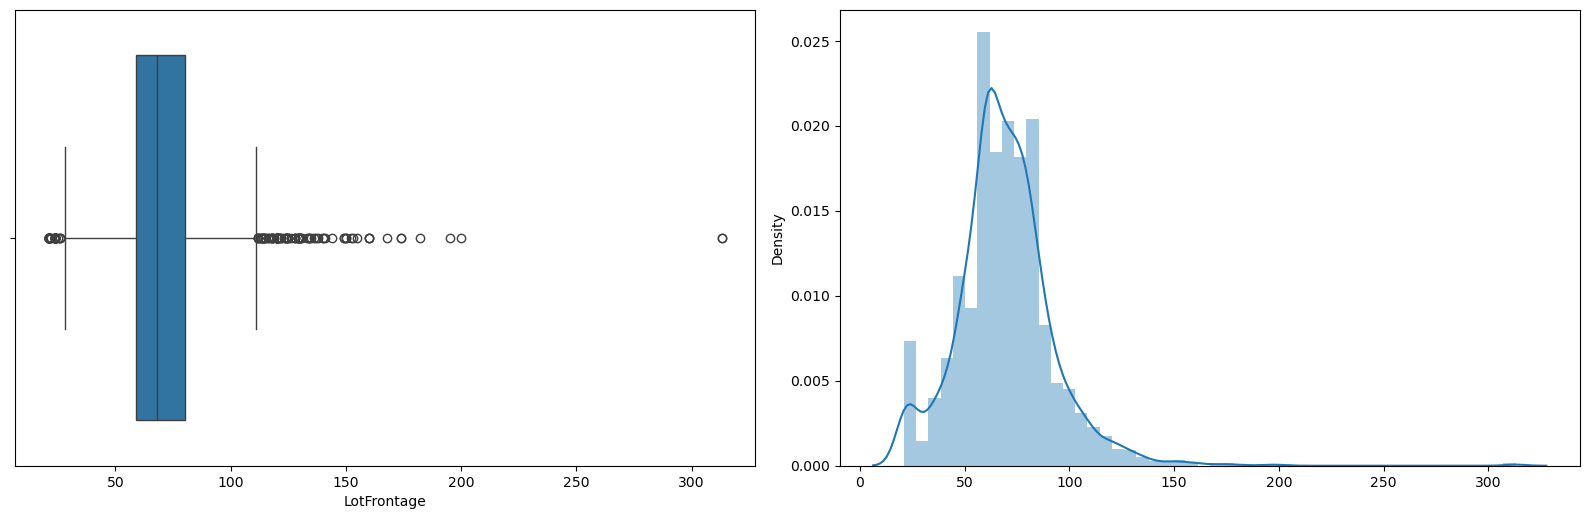

In [29]:
numPlot(df.LotFrontage)

In [30]:
lotfrontage_mean = df.LotFrontage.mean()
fill_null(df.LotFrontage, lotfrontage_mean)

0

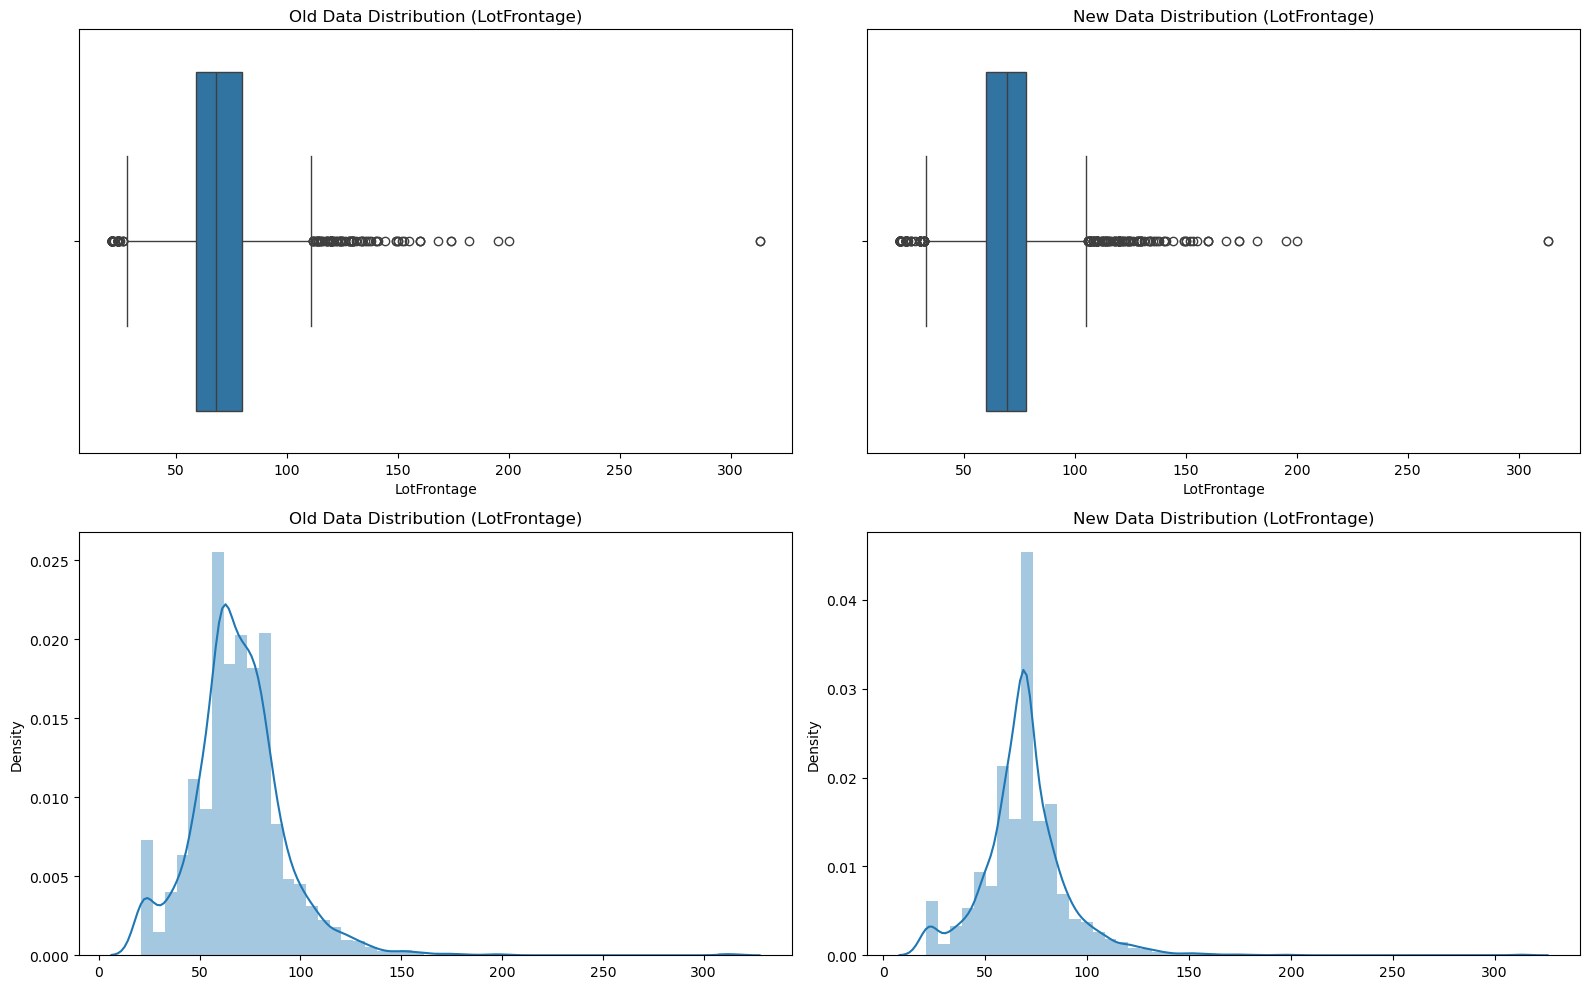

In [31]:
old_new_numplot('LotFrontage')

#### `3 : Alley`

In [32]:
null_feature_info(3)

       null_count       in_% data_type
Alley        2721  93.216855    object 



In [33]:
df.Alley.unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [34]:
df.Alley.value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

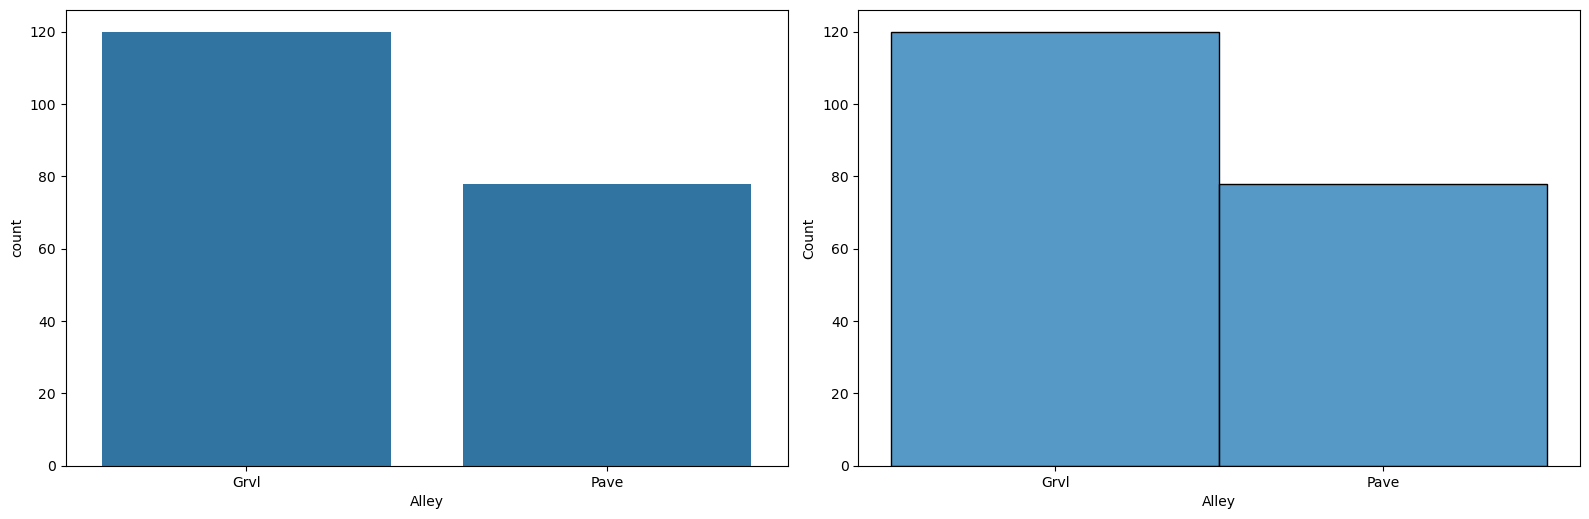

In [35]:
catPlot(df.Alley)

In [36]:
alley_cons = 'NA'
fill_null(df.Alley, alley_cons)

0

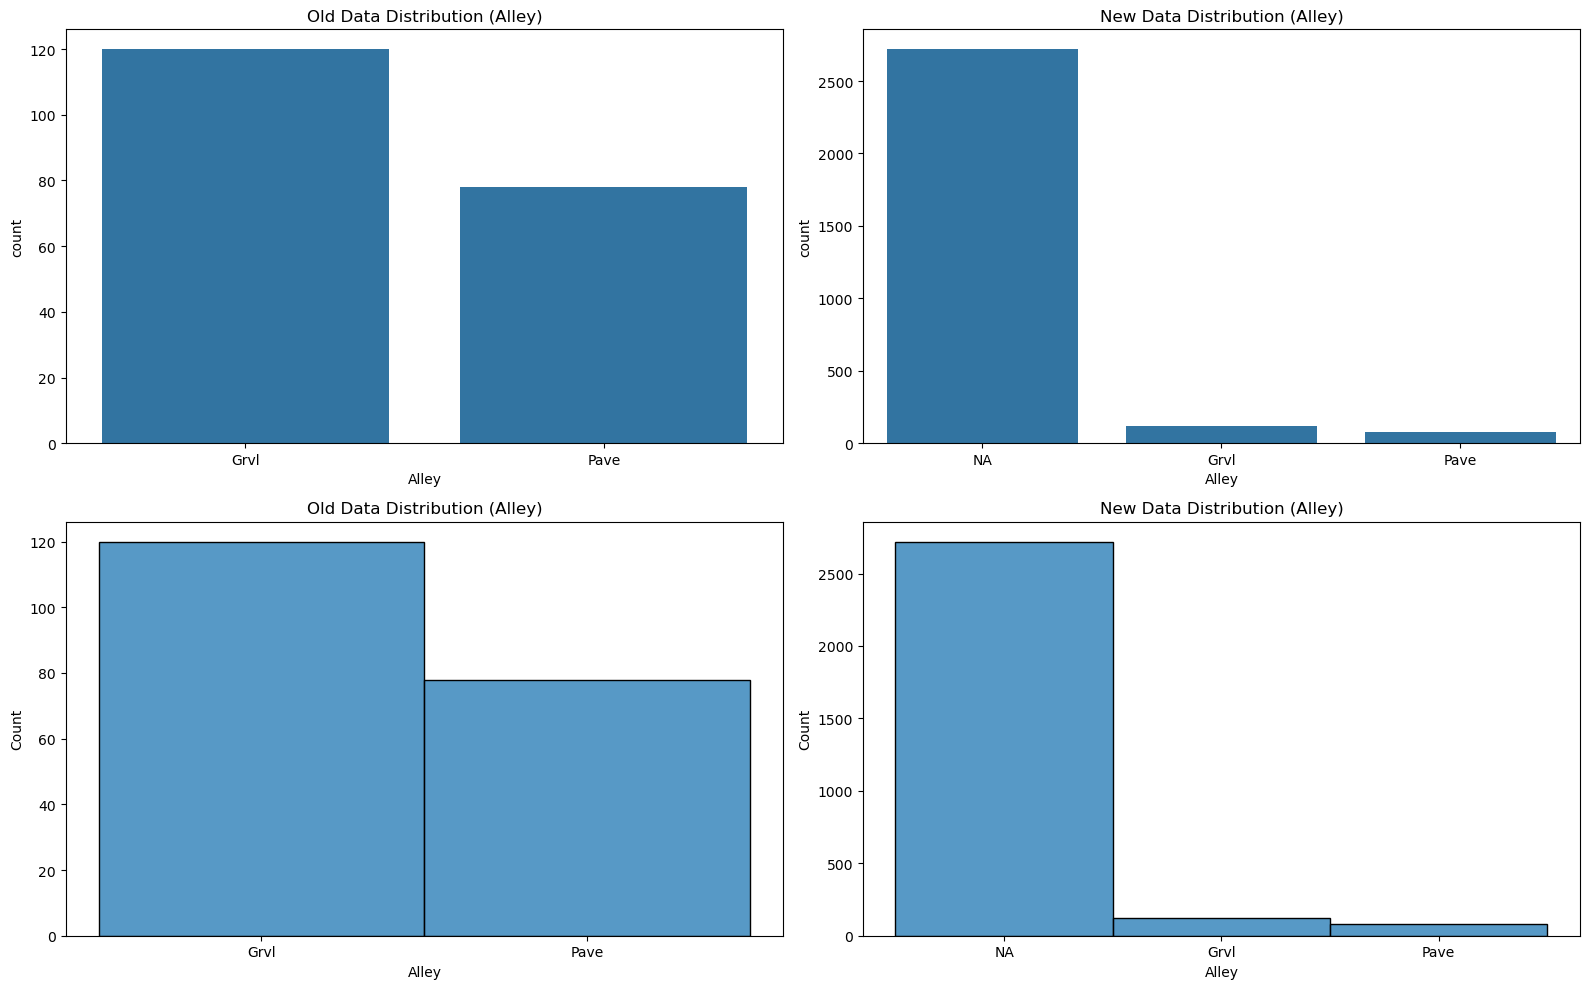

In [37]:
old_new_catplot('Alley')

#### `4 : Utilities`

In [38]:
null_feature_info(4)

           null_count      in_% data_type
Utilities           2  0.068517    object 



In [39]:
df.Utilities.unique()

array(['AllPub', 'NoSeWa', nan], dtype=object)

In [40]:
df.Utilities.value_counts()

Utilities
AllPub    2916
NoSeWa       1
Name: count, dtype: int64

In [41]:
utitlities_mode = df.Utilities.mode()[0]
fill_null(df.Utilities, utitlities_mode)

0

#### `5 : Exterior1st & Exterior2nd`

In [42]:
null_feature_info(5), null_feature_info(6);

             null_count      in_% data_type
Exterior1st           1  0.034258    object 

             null_count      in_% data_type
Exterior2nd           1  0.034258    object 



In [43]:
df.Exterior1st.unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock', nan], dtype=object)

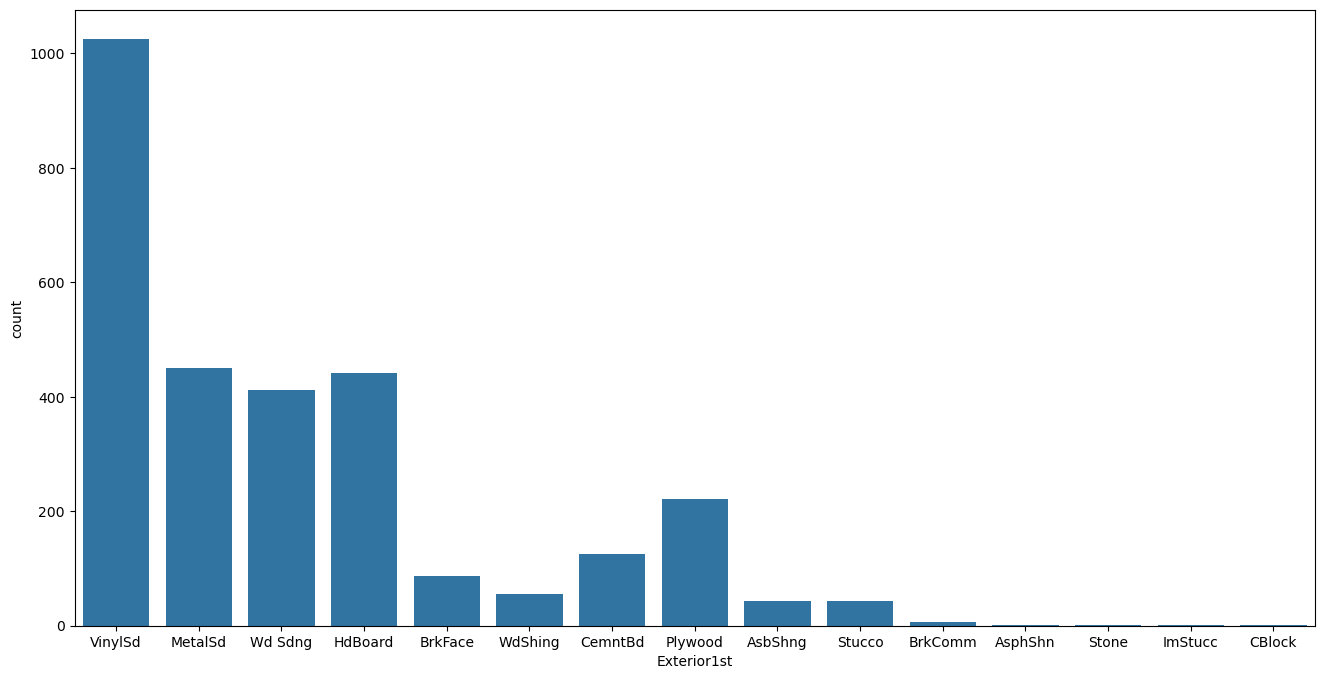

In [44]:
plt.figure(figsize=(16,8))
sns.countplot(x=df.Exterior1st)
plt.show()

In [45]:
exterior1st_mode = df.Exterior1st.mode()[0]
fill_null(df.Exterior1st, exterior1st_mode)

0

In [46]:
df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock', nan], dtype=object)

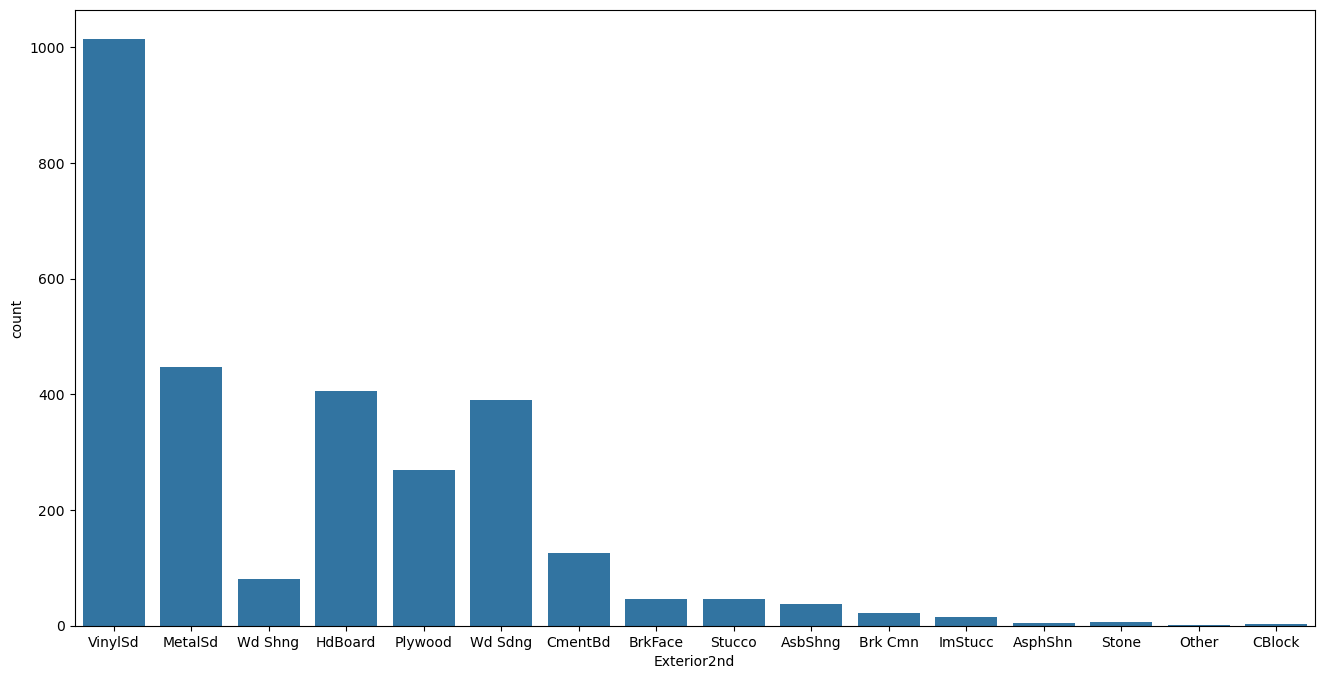

In [47]:
plt.figure(figsize=(16,8))
sns.countplot(x=df.Exterior2nd)
plt.show()

In [48]:
exterior2nd_mode = df.Exterior2nd.mode()[0]
fill_null(df.Exterior2nd, exterior2nd_mode)

0

#### `6 : MasVnrType & MasVnrArea `

In [49]:
null_feature_info(7), null_feature_info(8)

            null_count       in_% data_type
MasVnrType        1766  60.500171    object 

            null_count      in_% data_type
MasVnrArea          23  0.787941   float64 



(None, None)

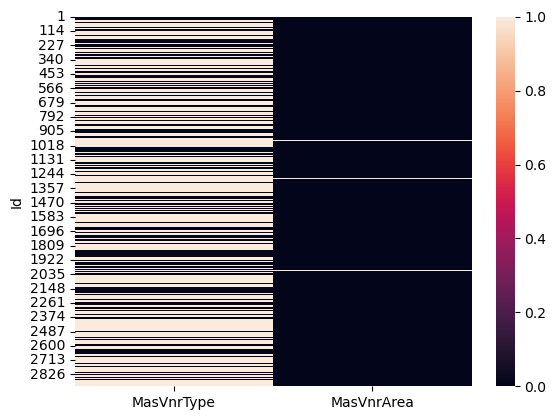

In [50]:
plt.figure()
sns.heatmap(df[['MasVnrType', 'MasVnrArea']].isnull())
plt.show()

In [51]:
df.MasVnrType.value_counts()

MasVnrType
BrkFace    879
Stone      249
BrkCmn      25
Name: count, dtype: int64

In [52]:
masvnrtype_mode = df.MasVnrType.mode()[0]
fill_null(df.MasVnrType, masvnrtype_mode)

0

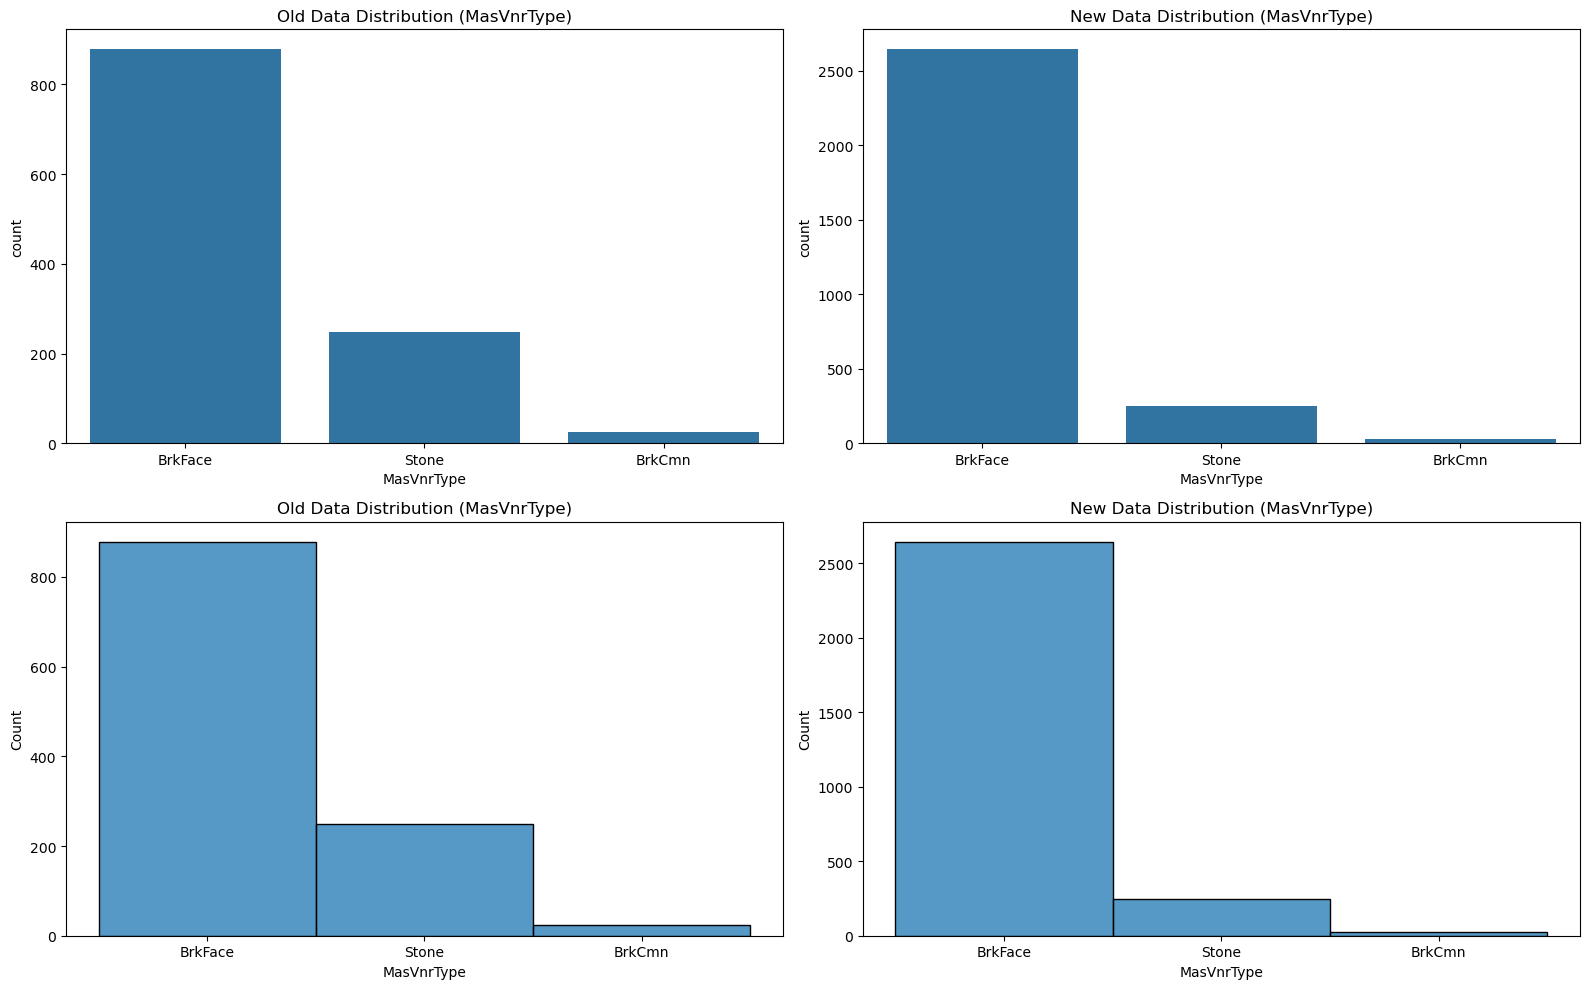

In [53]:
old_new_catplot('MasVnrType')

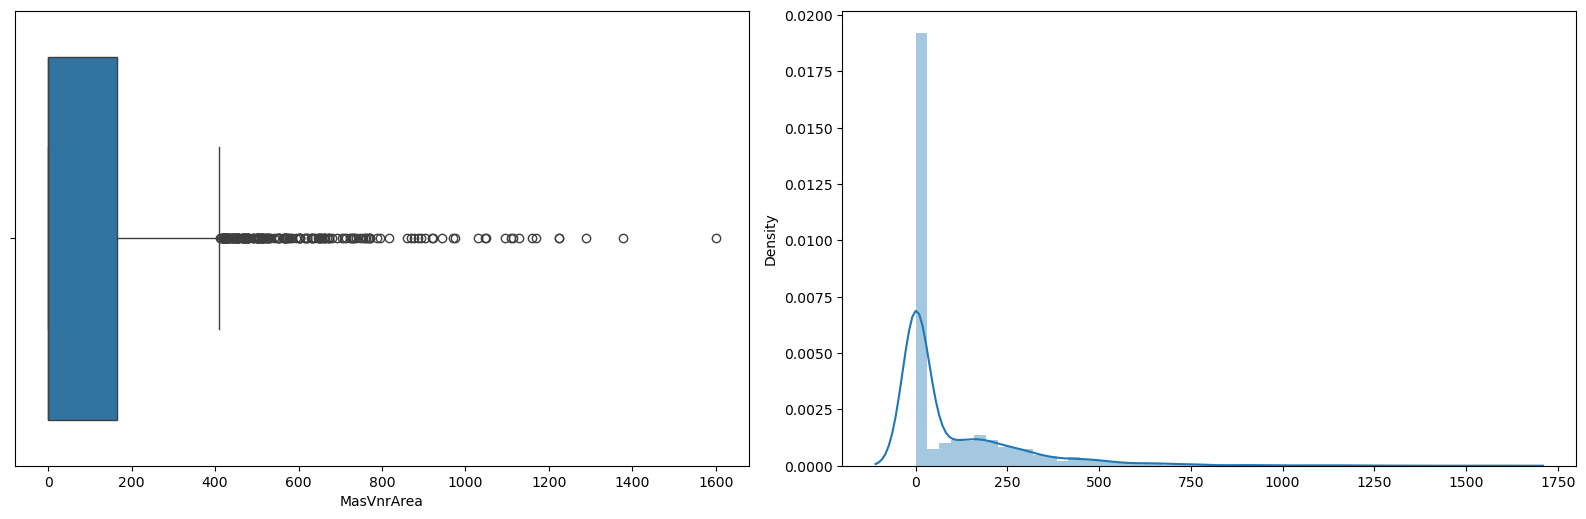

In [54]:
numPlot(df.MasVnrArea)

In [55]:
masvnrarea_cons = 0
fill_null(df.MasVnrArea, masvnrarea_cons)

0

#### `7 : All Bsmt features`

In [56]:
cat_bsmt_fea = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
num_bsmt_fea = ['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

<Axes: ylabel='Id'>

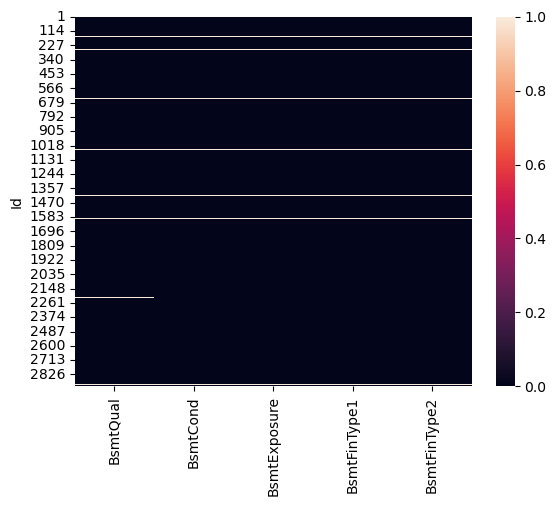

In [57]:
sns.heatmap(df[cat_bsmt_fea].isnull())

In [58]:
for fea in cat_bsmt_fea:
    print(f"Value counts of {fea} : {df[fea].value_counts()} \n")

Value counts of BsmtQual : BsmtQual
TA    1283
Gd    1209
Ex     258
Fa      88
Name: count, dtype: int64 

Value counts of BsmtCond : BsmtCond
TA    2606
Gd     122
Fa     104
Po       5
Name: count, dtype: int64 

Value counts of BsmtExposure : BsmtExposure
No    1904
Av     418
Gd     276
Mn     239
Name: count, dtype: int64 

Value counts of BsmtFinType1 : BsmtFinType1
Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: count, dtype: int64 

Value counts of BsmtFinType2 : BsmtFinType2
Unf    2493
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: count, dtype: int64 



In [59]:
bsmt_cons = 'NA'
for fea in cat_bsmt_fea:
    df[fea].replace(np.nan, bsmt_cons, inplace=True)
    print(fea, df[fea].isna().sum())

BsmtQual 0
BsmtCond 0
BsmtExposure 0
BsmtFinType1 0
BsmtFinType2 0


<Axes: ylabel='Id'>

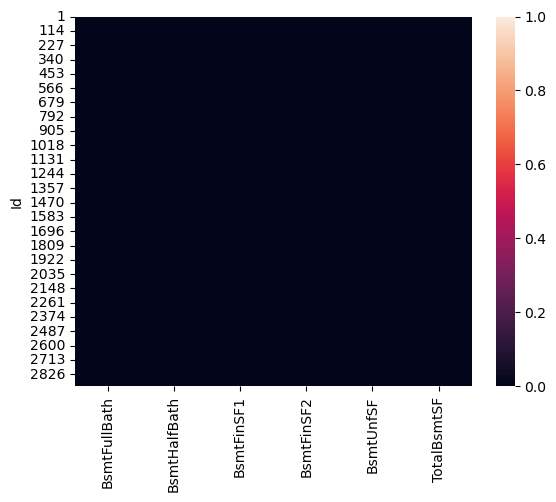

In [60]:
sns.heatmap(df[num_bsmt_fea].isnull())

In [61]:
bsmt_df = df[cat_bsmt_fea + num_bsmt_fea]
bsmt_df[bsmt_df.isnull().any(axis=1)]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
Id,,,,,,,,,,,
2121,NA,NA,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN
2189,NA,NA,NA,NA,NA,NaN,NaN,0.0,0.0,0.0,0.0


In [62]:
bsmt_num_cons = 0
for fea in num_bsmt_fea:
    df[fea].replace(np.nan, bsmt_num_cons, inplace=True)
    print(fea, df[fea].isna().sum())

BsmtFullBath 0
BsmtHalfBath 0
BsmtFinSF1 0
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0


#### `8 : Electrical`

In [63]:
df.Electrical.isnull().sum()

1

In [64]:
electrical_mode = df.Electrical.mode()[0]
fill_null(df.Electrical, electrical_mode)

0

#### `9 : KitchenQual`

In [65]:
df.KitchenQual.isnull().sum()

1

In [66]:
kitchenqual_mode = df.KitchenQual.mode()[0]
fill_null(df.KitchenQual, kitchenqual_mode)

0

#### `10 : Functional, FireplaceQu, PoolQC, Fence, MiscFeature, SaleType`

In [67]:
df.Functional.isnull().sum()

2

In [68]:
functional_mode = df.Functional.mode()[0]
fill_null(df.Functional, functional_mode)

0

In [69]:
df.FireplaceQu.isnull().sum()

1420

In [70]:
df.FireplaceQu.value_counts()

FireplaceQu
Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: count, dtype: int64

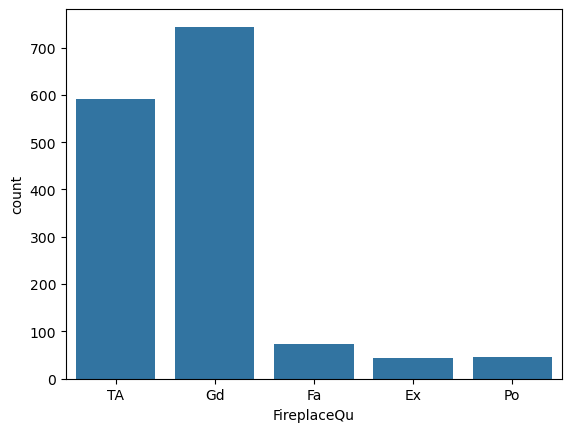

In [71]:
sns.countplot(x=df.FireplaceQu);

In [72]:
fireplacequ_cons = 'NA'
fill_null(df.FireplaceQu, fireplacequ_cons)

0

In [73]:
df.PoolQC.isnull().sum()

2909

In [74]:
df.PoolQC.value_counts()

PoolQC
Ex    4
Gd    4
Fa    2
Name: count, dtype: int64

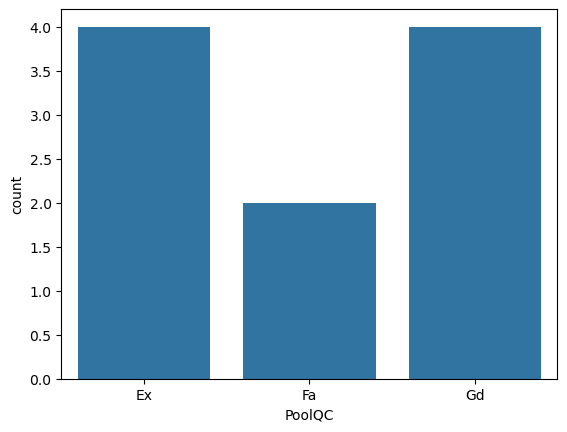

In [75]:
sns.countplot(x=df.PoolQC);

In [76]:
poolqc_cons = 'NA'
fill_null(df.PoolQC, poolqc_cons)

0

In [77]:
df.Fence.isnull().sum()

2348

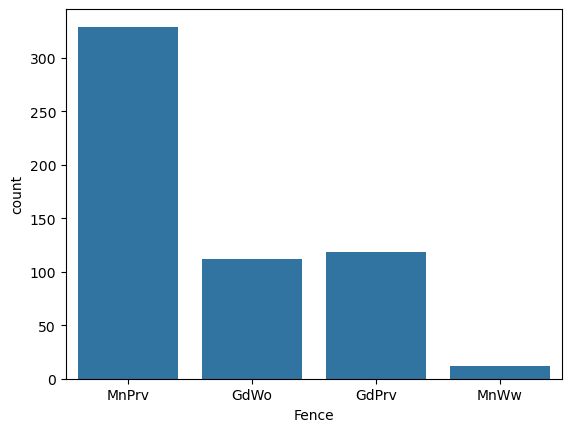

In [78]:
sns.countplot(x=df.Fence);

In [79]:
fence_cons = 'NA'
fill_null(df.Fence, fence_cons)

0

In [80]:
df.MiscFeature.isnull().sum()

2814

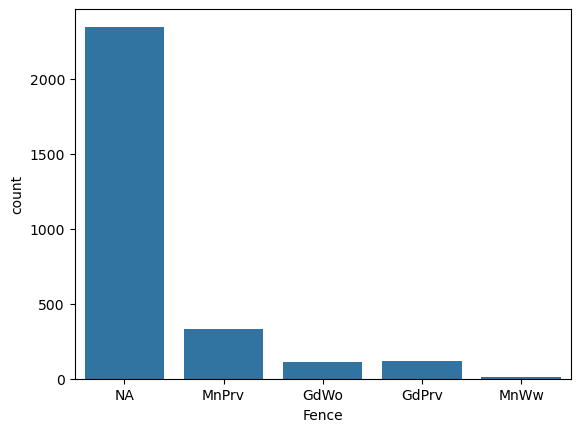

In [81]:
sns.countplot(x=df.Fence);

In [82]:
miscfeature_cons = 'NA'
fill_null(df.MiscFeature, miscfeature_cons)

0

In [83]:
df.SaleType.isnull().sum()

1

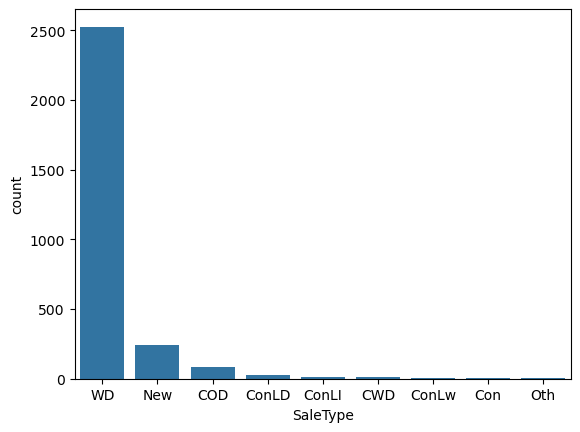

In [84]:
sns.countplot(x=df.SaleType);

In [85]:
saletype_mode = df.SaleType.mode()[0]
fill_null(df.SaleType,  saletype_mode)

0

#### `11 : All Garage features`

- GarageType, GarageFinish, GarageQual, GarageCond - (object) 
- GarageYrBlt, GarageCars, GarageArea - (float64)

In [86]:
df.GarageType.isnull().sum()

157

In [87]:
garagetype_cons = 'NA'
fill_null(df.GarageType, garagetype_cons)

0

In [88]:
df.GarageFinish.isnull().sum()

159

In [89]:
garagefinish_cons = 'NA'
fill_null(df.GarageFinish, garagefinish_cons)

0

In [90]:
df.GarageQual.isnull().sum()

159

In [91]:
garagequal_cons = 'NA'
fill_null(df.GarageQual, garagequal_cons)

0

In [92]:
df.GarageCond.isnull().sum()

159

In [93]:
garagecond_cons = 'NA'
fill_null(df.GarageCond, garagecond_cons)

0

In [94]:
df.GarageYrBlt.isnull().sum()

159

In [95]:
garageyrblt_cons = 0
fill_null(df.GarageYrBlt, garageyrblt_cons)

0

In [96]:
df.GarageCars.isnull().sum()

1

In [97]:
garagecars_cons = 0
fill_null(df.GarageCars, garagecars_cons)

0

In [98]:
df.GarageArea.isnull().sum()

1

In [99]:
garagearea_cons = 0
fill_null(df.GarageArea, garagearea_cons)

0

In [100]:
df.isnull().sum()

MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
                 ... 
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice        1459
Length: 80, dtype: int64

---

## ` - transforming data`

#### `convert numerical features into categorical features` 

In [101]:
for_num_conv = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

In [102]:
for fea in for_num_conv:
    print(f"{fea} : {df[fea].dtypes}")

MSSubClass : int64
YearBuilt : int64
YearRemodAdd : int64
GarageYrBlt : float64
MoSold : int64
YrSold : int64


In [103]:
df[for_num_conv].head()

,MSSubClass,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold
Id,,,,,,
1,60,2003,2003,2003.0,2,2008
2,20,1976,1976,1976.0,5,2007
3,60,2001,2002,2001.0,9,2008
4,70,1915,1970,1998.0,2,2006
5,60,2000,2000,2000.0,12,2008


In [104]:
df.MoSold = df.MoSold.apply(lambda x: calendar.month_abbr[x])

In [105]:
df[for_num_conv].head()

,MSSubClass,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold
Id,,,,,,
1,60,2003,2003,2003.0,Feb,2008
2,20,1976,1976,1976.0,May,2007
3,60,2001,2002,2001.0,Sep,2008
4,70,1915,1970,1998.0,Feb,2006
5,60,2000,2000,2000.0,Dec,2008


In [106]:
for fea in for_num_conv:
    df[fea] = df[fea].astype(str)

In [107]:
for fea in for_num_conv:
    print(f"{fea} : {df[fea].dtypes}")

MSSubClass : object
YearBuilt : object
YearRemodAdd : object
GarageYrBlt : object
MoSold : object
YrSold : object


#### `convert categorical features into numerical features`

##### `ordinal encoding`

In [108]:
print(data_description)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [109]:
df.ExterQual.value_counts()

ExterQual
TA    1798
Gd     979
Ex     107
Fa      35
Name: count, dtype: int64

In [110]:
df.ExterCond.value_counts()

ExterCond
TA    2538
Gd     299
Fa      67
Ex      12
Po       3
Name: count, dtype: int64

In [111]:
# cat order format
def catToNum(df, feature_list, order):
    for feature in feature_list:
        df[feature] = df[feature].astype(CategoricalDtype(categories=order, ordered=True)).cat.codes

In [112]:
catToNum(df, ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

In [113]:
df.ExterQual.value_counts()

ExterQual
2    1798
3     979
4     107
1      35
Name: count, dtype: int64

In [114]:
df.ExterCond.value_counts()

ExterCond
2    2538
3     299
1      67
4      12
0       3
Name: count, dtype: int64

In [115]:
df.BsmtQual.value_counts()

BsmtQual
TA    1283
Gd    1209
Ex     258
Fa      88
NA      81
Name: count, dtype: int64

In [116]:
catToNum(df, ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond'], ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])

In [117]:
df.BsmtQual.value_counts()

BsmtQual
3    1283
4    1209
5     258
2      88
0      81
Name: count, dtype: int64

In [118]:
df.BsmtFinType1.value_counts()

BsmtFinType1
Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
NA      79
Name: count, dtype: int64

In [119]:
df.GarageCond.value_counts()

GarageCond
3    2654
0     159
2      74
4      15
1      14
5       3
Name: count, dtype: int64

In [120]:
catToNum(df, ['BsmtFinType1', 'BsmtFinType2'], ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'])

In [121]:
df.BsmtFinType1.value_counts()

BsmtFinType1
1    851
6    849
5    429
3    288
4    269
2    154
0     79
Name: count, dtype: int64

In [122]:
catToNum(df, ['BsmtExposure'], ['NA', 'No', 'Mn', 'Av', 'Gd'])

In [123]:
df.BsmtExposure.value_counts()

BsmtExposure
1    1904
3     418
4     276
2     239
0      82
Name: count, dtype: int64

In [124]:
print(data_description)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [125]:
df.PoolQC = df.PoolQC.astype(CategoricalDtype(categories=['NA', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)).cat.codes
df.Functional = df.Functional.astype(CategoricalDtype(categories=['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], ordered=True)).cat.codes
df.GarageFinish = df.GarageFinish.astype(CategoricalDtype(categories=['NA', 'Unf', 'RFn', 'Fin'], ordered=True)).cat.codes
df.PavedDrive = df.PavedDrive.astype(CategoricalDtype(categories=['N', 'P', 'Y'], ordered=True)).cat.codes
df.Utilities = df.Utilities.astype(CategoricalDtype(categories=['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], ordered=True)).cat.codes

In [126]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,3,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,4,3,1,6,706.0,1,0.0,150.0,856.0,GasA,4,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,3,8,7,0,0,Attchd,2003.0,2,2.0,548.0,3,3,2,0,61,0,0,0,0,0,NA,NA,0,Feb,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,3,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,2,2,CBlock,4,3,4,5,978.0,1,0.0,284.0,1262.0,GasA,4,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,2,6,7,1,3,Attchd,1976.0,2,2.0,460.0,3,3,2,298,0,0,0,0,0,0,NA,NA,0,May,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,3,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,4,3,2,6,486.0,1,0.0,434.0,920.0,GasA,4,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,3,6,7,1,3,Attchd,2001.0,2,2.0,608.0,3,3,2,0,42,0,0,0,0,0,NA,NA,0,Sep,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,3,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,0.0,2,2,BrkTil,3,4,1,5,216.0,1,0.0,540.0,756.0,GasA,3,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,3,7,7,1,4,Detchd,1998.0,1,3.0,642.0,3,3,2,0,35,272,0,0,0,0,NA,NA,0,Feb,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,3,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,4,3,3,6,655.0,1,0.0,490.0,1145.0,GasA,4,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,3,9,7,1,3,Attchd,2000.0,2,3.0,836.0,3,3,2,192,84,0,0,0,0,0,NA,NA,0,Dec,2008,WD,Normal,250000.0


#### `one hot encoding for nominal categorical data`

In [127]:
df_encod = df.copy()

obj_fea = df_encod.select_dtypes(include='object').columns.tolist()
print(obj_fea)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'GarageYrBlt', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [128]:
df_encod[obj_fea].head(3)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,GarageYrBlt,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NA,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,2003.0,NA,NA,Feb,2008,WD,Normal
2,20,RL,Pave,NA,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,1976,1976,Gable,CompShg,MetalSd,MetalSd,BrkFace,CBlock,GasA,Y,SBrkr,Attchd,1976.0,NA,NA,May,2007,WD,Normal
3,60,RL,Pave,NA,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,2001.0,NA,NA,Sep,2008,WD,Normal


In [129]:
print(f'shape before: {df_encod.shape}')

df_encod = pd.get_dummies(df_encod, 
                          columns=obj_fea, 
                          prefix=obj_fea, 
                          drop_first=True,
                          dtype=int)

print(f'shape after: {df_encod.shape}')

shape before: (2919, 80)
shape after: (2919, 512)


In [130]:
df_encod.head(3)

,LotFrontage,LotArea,Utilities,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,SalePrice,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_NA,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,YearBuilt_2001,YearBuilt_2002,YearBuilt_2003,YearBuilt_2004,YearBuilt_2005,YearBuilt_2006,YearBuilt_2007,YearBuilt_2008,YearBuilt_2009,YearBuilt_2010,YearRemodAdd_1951,YearRemodAdd_1952,YearRemodAdd_1953,YearRemodAdd_1954,YearRemodAdd_1955,YearRemodAdd_1956,YearRemodAdd_1957,YearRemodAdd_1958,YearRemodAdd_1959,YearRemodAdd_1960,YearRemodAdd_1961,YearRemodAdd_1962,YearRemodAdd_1963,YearRemodAdd_1964,YearRemodAdd_1965,YearRemodAdd_1966,YearRemodAdd_1967,YearRemodAdd_19

In [131]:
df_encod.select_dtypes(include='object').columns.tolist()

[]

In [132]:
df_encod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Columns: 512 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(11), int32(464), int64(20), int8(17)
memory usage: 5.9 MB


## `spilt data for traning and testing`

In [133]:
df_encod.shape

(2919, 512)

In [134]:
len_train = df_train.shape[0]
len_train


1460

In [135]:
X_data = df_encod[:len_train].drop('SalePrice', axis=1)
y_data = df_encod.SalePrice[:len_train]
test_data = df_encod[len_train:].drop('SalePrice', axis=1)


In [136]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=1)

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)


## `feature scaling`

In [137]:
sc = StandardScaler()
sc.fit(X_train);


In [138]:
X_train = pd.DataFrame(sc.transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))


test_data = pd.DataFrame(sc.transform(test_data))
test_data.to_csv('./model_pkl/X_test.csv', index=False)


In [140]:
print(f"Train : {X_train.shape}, {y_train.shape}")
print(f"Test  : {X_test.shape}, {y_test.shape}")


Train : (1095, 511), (1095, 1)
Test  : (365, 511), (365, 1)


## `choose model`

In [141]:
gbr = GradientBoostingRegressor(random_state=1)
xgbr = XGBRegressor(random_state=1)

models = {
    'GradientBoostingRegressor': gbr,
    'XGBRegressor': xgbr
}


In [142]:
# Define the parameter grids
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

param_grid_xgbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

param_grids = {
    'GradientBoostingRegressor': param_grid_gbr,
    'XGBRegressor': param_grid_xgbr
}


In [143]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
r2 = make_scorer(r2_score)

def test_model(model, X_train, y_train, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    r2_val_score = cross_val_score(best_model, X_train, y_train, cv=cv, scoring=r2)
    score = r2_val_score.mean()
    return score, grid_search.best_params_


## `train model`

In [144]:
models_score = []
for model_name in models:
    print(f"Training model: {model_name}")
    score, best_params = test_model(models[model_name], X_train, y_train, param_grids[model_name])
    print(f"Score of model: {score}")
    print(f"Best parameters: {best_params}\n")
    models_score.append([model_name, score, best_params])

models_score


Training model: GradientBoostingRegressor
Score of model: 0.8695129077529445
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Training model: XGBRegressor
Score of model: 0.8777909696102142
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}



[['GradientBoostingRegressor',
  0.8695129077529445,
  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}],
 ['XGBRegressor',
  0.8777909696102142,
  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}]]

In [145]:
para_gbr = list(models_score[0][2].values())
para_xgbr = list(models_score[1][2].values())


In [146]:
# Initialize GradientBoostingRegressor and XGBRegressor with best parameters
best_gbr = GradientBoostingRegressor(learning_rate=para_gbr[0], max_depth=para_gbr[1], n_estimators=para_gbr[2], random_state=1)
best_xgbr = XGBRegressor(learning_rate=para_xgbr[0], max_depth=para_xgbr[1], n_estimators=para_xgbr[2], random_state=1)


In [147]:
# Fit the models on the entire training data
best_gbr.fit(X_train, y_train)
best_xgbr.fit(X_train, y_train);


In [ ]:
# Make predictions on the test data
gbr_predictions = best_gbr.predict(X_test)
xgbr_predictions = best_xgbr.predict(X_test)


In [ ]:
# Evaluate the models using appropriate metrics
gbr_r2 = r2_score(y_test, gbr_predictions)
xgbr_r2 = r2_score(y_test, xgbr_predictions)

gbr_mse = mean_squared_error(y_test, gbr_predictions)
xgbr_mse = mean_squared_error(y_test, xgbr_predictions)

gbr_mae = mean_absolute_error(y_test, gbr_predictions)
xgbr_mae = mean_absolute_error(y_test, xgbr_predictions)


In [ ]:
# Print the evaluation results
print("GradientBoostingRegressor:")
print("R² Score:", gbr_r2)
print("Mean Squared Error:", gbr_mse)
print("Mean Absolute Error:", gbr_mae)

print("\nXGBRegressor:")
print("R² Score:", xgbr_r2)
print("Mean Squared Error:", xgbr_mse)
print("Mean Absolute Error:", xgbr_mae)


In [ ]:
y_test = np.array(y_test).reshape(y_test.shape[0])
y_test.shape


In [ ]:
# Calculate residuals
gbr_residuals = y_test - gbr_predictions
xgbr_residuals = y_test - xgbr_predictions


In [ ]:
# Calculate residuals in percentage
gbr_residuals_percentage = (gbr_residuals / y_test) * 100
xgbr_residuals_percentage = (xgbr_residuals / y_test) * 100


In [ ]:
# Create a comparison dataframe
pd.options.display.float_format = '{:.3f}'.format
comparison_df = pd.DataFrame({
    'y': y_test,
    'gbr_y_hat': gbr_predictions[0],
    'xgbr_y_hat': xgbr_predictions[0],
    'gbr_residuals': gbr_residuals[0],
    'xgbr_residuals': xgbr_residuals[0],
    'gbr_residuals_%': gbr_residuals_percentage[0],
    'xgbr_residuals_%': xgbr_residuals_percentage[0]
})


In [ ]:
comparison_df.head(3)


In [ ]:
comparison_df.T


In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(comparison_df.gbr_residuals, kde=True)
plt.title('GradientBoostingRegressor Residuals')
plt.xlabel('Residuals')

plt.subplot(1, 2, 2)
sns.histplot(comparison_df.xgbr_residuals, kde=True)
plt.title('XGBRegressor Residuals')
plt.xlabel('Residuals')

plt.show()


In [ ]:
# Additional metrics: Mean Absolute Percentage Error (MAPE) and Symmetric Mean Absolute Percentage Error (SMAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2.0 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

gbr_mape = mean_absolute_percentage_error(y_test, gbr_predictions)
xgbr_mape = mean_absolute_percentage_error(y_test, xgbr_predictions)

gbr_smape = symmetric_mean_absolute_percentage_error(y_test, gbr_predictions)
xgbr_smape = symmetric_mean_absolute_percentage_error(y_test, xgbr_predictions)


In [ ]:
print("GradientBoostingRegressor MAPE:", gbr_mape)
print("GradientBoostingRegressor SMAPE:", gbr_smape)

print("\nXGBRegressor MAPE:", xgbr_mape)
print("XGBRegressor SMAPE:", xgbr_smape)


In [ ]:
# Extract feature importances from the models
feature_importances_gbr = best_gbr.feature_importances_
feature_importances_xgbr = best_xgbr.feature_importances_

# Set the number of top features to display
N = 30

# Get indices of top N features
top_indices_gbr = np.argsort(feature_importances_gbr)[-N:]
top_indices_xgbr = np.argsort(feature_importances_xgbr)[-N:]

# Extract the names of the top features
top_features_gbr = X_data.columns[top_indices_gbr]
top_features_xgbr = X_data.columns[top_indices_xgbr]

# Extract the importance values for the top features
top_importances_gbr = feature_importances_gbr[top_indices_gbr]
top_importances_xgbr = feature_importances_xgbr[top_indices_xgbr]

# Create DataFrames for easier plotting
df_top_features_gbr = pd.DataFrame({
    'Feature': top_features_gbr,
    'Importance': top_importances_gbr
}).sort_values(by='Importance', ascending=False)

df_top_features_xgbr = pd.DataFrame({
    'Feature': top_features_xgbr,
    'Importance': top_importances_xgbr
}).sort_values(by='Importance', ascending=False)


In [ ]:
# Plotting the top N features
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
sns.barplot(data=df_top_features_gbr, x='Importance', y='Feature', palette='viridis')
plt.title(f'Top {N} Features - GradientBoostingRegressor')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

plt.subplot(2, 1, 2)
sns.barplot(data=df_top_features_xgbr, x='Importance', y='Feature', palette='viridis')
plt.title(f'Top {N} Features - XGBRegressor')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()


In [ ]:
# Compare and select the best model
if gbr_r2 > xgbr_r2:
    final_model = best_gbr
    final_model_name = 'GradientBoostingRegressor'
else:
    final_model = best_xgbr
    final_model_name = 'XGBRegressor'

print(f"\nThe best model is: {final_model_name}")


import joblib

# Save the final model
joblib.dump(final_model, './model_pkl/final_model.pkl')
joblib.dump(best_xgbr, './model_pkl/xgbr.pkl')
print(f"The final model '{final_model_name}' has been saved as 'final_model.pkl'")
